make surface structures.

In [ ]:
from wizard.atoms import SymbolInfo
from wizard.calculator import MaterialCalculator
from calorine.calculators import CPUNEP
from itertools import combinations_with_replacement
import numpy as np
from math import gcd
from tqdm import tqdm

hmax = 3

# set up hkls
hkls_cubic = set()
for hkl in combinations_with_replacement(range(hmax + 1), 3):
    hkl = tuple(np.array(np.array(hkl) / gcd(*hkl), dtype=int))
    if sum(hkl) <= 0:
        continue
    hkls_cubic.add(hkl)

hkls_hexagonal = set()
for l in range(0, hmax+1):
    for h, k in combinations_with_replacement(range(hmax + 1), 2):
        hkl = (h, k, l)
        hkl = tuple(np.array(np.array(hkl) / gcd(*hkl), dtype=int))
        if sum(hkl) <= 0:
            continue
        hkls_hexagonal.add(hkl)

symbol_infos = [
SymbolInfo('Ag', 'fcc', 4.146),
SymbolInfo('Al', 'fcc', 4.042),
SymbolInfo('Au', 'fcc', 4.159),
SymbolInfo('Cu', 'fcc', 3.631),
SymbolInfo('Ni', 'fcc', 3.509),
SymbolInfo('Pb', 'fcc', 5.038),
SymbolInfo('Pd', 'fcc', 3.939),
SymbolInfo('Pt', 'fcc', 3.967),
SymbolInfo('Cr', 'bcc', 2.845),
SymbolInfo('Mo', 'bcc', 3.164),
SymbolInfo('Ta', 'bcc', 3.319),
SymbolInfo('V',  'bcc', 2.997),
SymbolInfo('W',  'bcc', 3.185),
SymbolInfo('Mg', 'hcp', 3.195, 5.186),
SymbolInfo('Ti', 'hcp', 2.931, 4.651),
SymbolInfo('Zr', 'hcp', 3.240, 5.157)
]

for symbol_info in symbol_infos:
    atoms = symbol_info.create_bulk_atoms((1,1,1))
    calc = CPUNEP('../../potentials/4-4-80/nep.txt')
    material_calculator = MaterialCalculator(atoms, calc, symbol_info)
    if symbol_info.structure == 'hcp':
        hkls = hkls_hexagonal
    else:
        hkls = hkls_cubic
    for hkl in hkls:
        material_calculator.formation_energy_surface(hkl=hkl, layers = 15) 

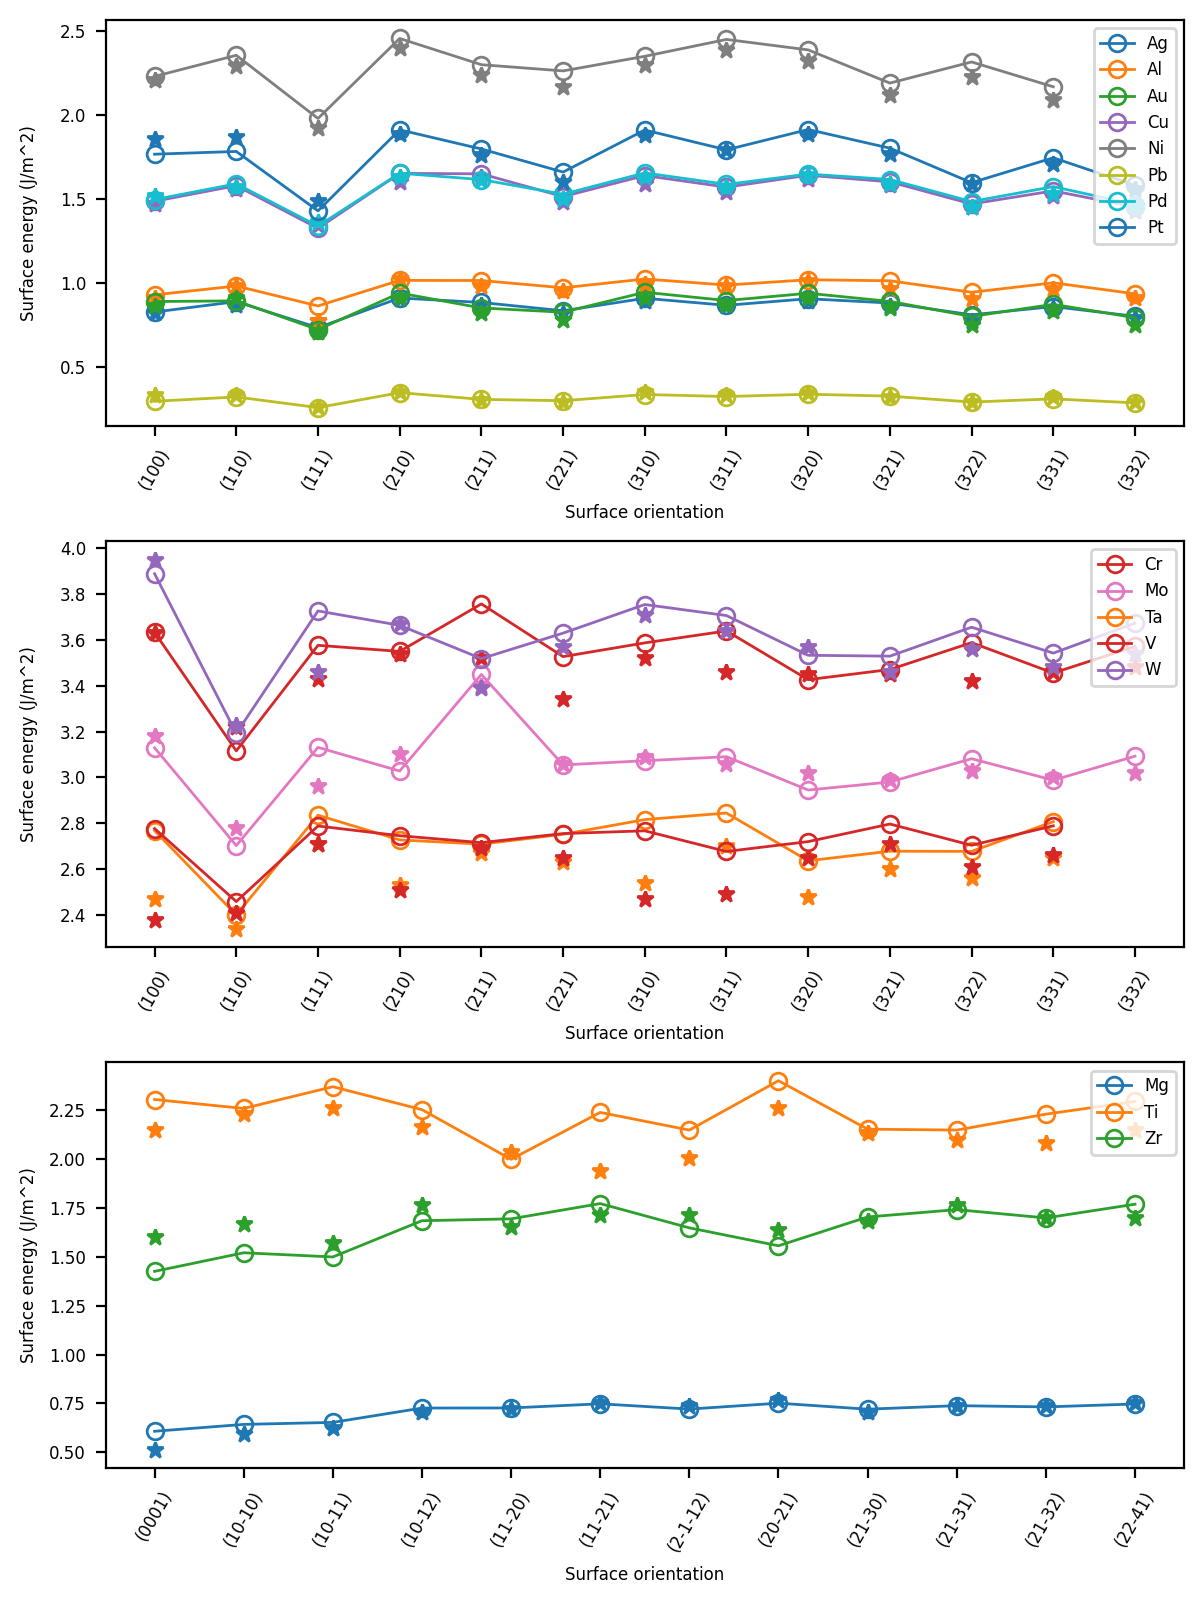

In [13]:
from matplotlib import pyplot as plt
from ase.data import chemical_symbols, reference_states
from pandas import DataFrame
import json

with open('data.json', 'r') as f:
    data = json.load(f)

df_surface_energies = DataFrame.from_dict(data)

crystal_structures = {s: r['symmetry'] if r is not None else None
                      for s, r in zip(chemical_symbols, reference_states)}


plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 6
fig, axes = plt.subplots(
    figsize=(6, 8),
    dpi=200,
    nrows=3,
    sharex = False,
    sharey=False
)

for k, (species, df) in enumerate(df_surface_energies.groupby('species')):
    structure = crystal_structures[species]
    if structure == 'hcp':
        continue
    irow = 0 if structure == 'fcc' else 1
    ax = axes[irow]
    df.reset_index(inplace=True)
    df.sort_values('hkl', inplace=True)  
    df.reset_index(drop=True, inplace=True)
    color = f'C{k}'
    ax.plot(df.gamma_NEP, 'o-', color=color, label=species, fillstyle='none', markersize=6, linewidth=1)
    ax.plot(df.gamma_DFT, '*', color=color, markersize=6, linewidth=1)
    ax.legend(loc='upper right')
    ax.set_xticks(range(len(df.hkl)))
    ax.set_xticklabels(df.hkl, rotation=60)
    ax.set_xlabel('Surface orientation')
    ax.set_ylabel('Surface energy (J/m^2)')

for k, (species, df) in enumerate(df_surface_energies[df_surface_energies['species'].isin(['Mg', 'Zr', 'Ti'])].groupby('species')):
    df.reset_index(inplace=True)
    df.sort_values('hkl', inplace=True)  
    df.reset_index(drop=True, inplace=True)
    color = f'C{k}'
    axes[2].plot(df.gamma_NEP, 'o-', color=color, label=species, fillstyle='none', markersize=6, linewidth=1)
    axes[2].plot(df.gamma_DFT, '*', color=color, markersize=6, linewidth=1)
    axes[2].legend(loc='upper right')
    axes[2].set_xticks(range(len(df.hkl)))
    axes[2].set_xticklabels(df.hkl, rotation=60)
    axes[2].set_xlabel('Surface orientation')
    axes[2].set_ylabel('Surface energy (J/m^2)')

fig.tight_layout()
fig.align_ylabels(axes)

plt.savefig('surface_energies.png')